In [231]:
# import modules
import numpy as np
# astropy provides unit system for astronomical calculations
import astropy.units as u
# astropy also offer a module for showinng results in a table
import astropy.table as tbl
# import previous HW functions
from ReadFile import Read
import matplotlib
import matplotlib.pyplot as plt
from astropy.constants import G
global G
%matplotlib inline

In [232]:
class CenterOfMass:
    """ Hold the COM position & velocity of a galaxy at a given snapshot """

    
    
    def __init__(self, filename, ptype):
        """ Initialize this class with relevant data """
    
        # read in the file                                                                                             
        self.time, self.total, self.data = Read(filename)
        #print(self.time)                                                                                              

        #create an array to store indexes of particles of desired Ptype                                                
        self.index = np.where(self.data['type'] == ptype)

        # store the mass, positions, velocities of only the particles of the given type                                
        self.m = self.data['m'][self.index]
        self.x = self.data['x'][self.index]
        self.y = self.data['y'][self.index]
        self.z = self.data['z'][self.index]
        self.vx = self.data['vx'][self.index]
        self.vy = self.data['vy'][self.index]
        self.vz = self.data['vz'][self.index]



    def COMdefine(self,a,b,c,m):
    # Function to compute the center of mass position or velocity generically                                          
    # input: array (a,b,c) of positions or velocities and the mass                                                     
    # returns: 3 floats  (the center of mass coordinates)                                                              

        # note: since all particles have the same                                                                      
        # mass, when we consider only one type,                                                                             
        # the below is equivalently np.sum(x)/len(x)                                                                   

        # xcomponent Center of mass                                                                                    
        Acom = np.sum(a*m)/np.sum(m)
        # ycomponent Center of mass                                                                                    
        Bcom = np.sum(b*m)/np.sum(m)
        # zcomponent                                                                                                   
        Ccom = np.sum(c*m)/np.sum(m)
        return Acom, Bcom, Ccom
    
    
    def COM_P(self, delta):
        """ Iteratively determine the COM position """
    # input:                                                                                                           
    #        delta (tolerance)                                                                                         
    # returns: One vector, with rows indicating:                                                                                                                                                                            
    #       3D coordinates of the center of mass position (kpc)                                                             



        # Center of Mass Position                                                                                      
        ###########################                                                                                    

        # Try a first guess at the COM position by calling COMdefine                                                   
        XCOM, YCOM, ZCOM = self.COMdefine(self.x,self.y,self.z,self.m)
        # compute the magnitude of the COM position vector.                                                            
        RCOM = np.sqrt(XCOM**2 + YCOM**2 + ZCOM**2)
        # print('init R', RCOM)                                                                                        


        # iterative process to determine the center of mass                                                            

        # change reference frame to COM frame                                                                          
        # compute the difference between particle coordinates                                                          
        # and the first guess at COM position                                                                          
        xNew = self.x - XCOM
        yNew = self.y - YCOM
        zNew = self.z - ZCOM
        RNEW = np.sqrt(xNew**2.0 + yNew**2.0 +zNew**2.0)

        # find the max 3D distance of all particles from the guessed COM                                               
        # will re-start at half that radius (reduced radius)                                                           
        RMAX = max(RNEW)/2.0
        
        # pick an initial estimate for the change in COM position                                                      
        # between the first guess above and the new one computed from half that volume.                                
        CHANGE = 1000.0

        # start iterative process to determine center of mass position                                                 
        # delta is the tolerance for the difference in the old COM and the new one.    
        
        while (CHANGE > delta):
          # select all particles within the reduced radius (starting from original x,y,z, m)                         
            index2 = np.where(RNEW < RMAX)
            x2 = self.x[index2]
            y2 = self.y[index2]
            z2 = self.z[index2]
            m2 = self.m[index2]

            # Refined COM position:                                                                                    
            # compute the center of mass position using                                                                
            # the particles in the reduced radius                                                                      
            XCOM2, YCOM2, ZCOM2 = self.COMdefine(x2,y2,z2,m2)
            # compute the new 3D COM position                                                                          
            RCOM2 = np.sqrt(XCOM2**2 + YCOM2**2 + ZCOM2**2)

            # determine the difference between the previous center of mass position                                    
            # and the new one.                                                                                         
            CHANGE = np.abs(RCOM - RCOM2)
            # check this                                                                                               
            # print ("DIFF", diff)                                                                                     

            # Before loop continues, reset : RMAX, particle separations and COM                                        

            # reduce the volume by a factor of 2 again                                                                 
            RMAX = RMAX/2.0
            # check this.                                                                                              
            #print ("maxR", maxR)                                                                                      

          # Change the frame of reference to the newly computed COM.                                                 
            # subtract the new COM                                                                                     
            xNew = self.x - XCOM2
            yNew = self.y - YCOM2
            zNew = self.z - ZCOM2
            RNEW = np.sqrt(xNew**2 + yNew**2 + zNew**2)



            # set the center of mass positions to the refined values                                                   
            XCOM = XCOM2
            YCOM = YCOM2
            ZCOM = ZCOM2
            RCOM = RCOM2

            # create a vector to store the COM position                                                                
                                                                                                 
            COMP = [XCOM,YCOM,ZCOM]

        # return the COM positon vector
        # set the correct units using astropy                                                                      
        # round all values 
        return np.round(COMP,2)*u.kpc


In [239]:
class MassProfile:
    """Plot the Mass and Velocity Profile """
    
    def __init__(self, Galaxy, Snap):
        """ Initialize this class with relevant data """
        #store the galaxy name 
        self.gname = Galaxy
        
        #add Snap to make file name
        ilbl = '000' + str(Snap)
        ilbl = ilbl[-3:]
        self.filename="%s_"%(Galaxy) + ilbl + '.txt'
        
        # read in the file                                                                                             
        self.time, self.total, self.data = Read(self.filename)

        # store the mass, positions, velocities of only the particles of the given type                                
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        
    def MassEnclosed(self, ptype, radius):
        # Function to compute the mass enclosed within a given radius of 
        # the COM position for a specified galaxy and a specified component
        # Input:
        #     ptype: type of galaxy component 1: halo 2: disk 3: bulge
        #     radius: 1D np array of radius not include 0
        # return: mass enclose in each radius bin
        GCOM = CenterOfMass(self.filename, ptype)
        GCOM_P = GCOM.COM_P(0.1)
        index = np.where(self.data['type'] == ptype)
        newdata = self.data[index]
        massenclose = np.zeros(len(radius))
        for i in range(len(radius)):
            
            temp_index = 0
            temp_mass = 0
            
            temp_index = np.where(((newdata['x']*u.kpc-GCOM_P[0])**2+(newdata['y']*u.kpc-GCOM_P[1])**2+
                                   (newdata['z']*u.kpc-GCOM_P[2])**2) <= radius[i]*u.kpc**2)
            temp_mass = sum(newdata['m'][temp_index])
            massenclose[i] = temp_mass
        
        return massenclose*1e10*u.Msun

    def MassEnclosedTotal(self, radius):
        # Function to compute the mass enclosed within a given radius of 
        # the COM position for a specified galaxy and all the component
        # Input:
        #     radius: 1D np array of radius not include 0
        # return: total mass enclose in each radius bin

        if self.gname != 'M33':
            HaloMass = self.MassEnclosed(1,radius)
            DiskMass = self.MassEnclosed(2,radius)
            BulgeMass = self.MassEnclosed(3,radius)  
            TotalMass = HaloMass+DiskMass+BulgeMass
        else:
            HaloMass = self.MassEnclosed(1,radius)
            DiskMass = self.MassEnclosed(2,radius)
            TotalMass = HaloMass+DiskMass
        return TotalMass
    
    def HernquistMass(self, a, radius):
        # Function to compute the mass enclosed within a given radius of 
        # Hernquist mass profile
        # Input:
        #     a: scale factor
        #     radius: 1D np array of radius not include 0
        #     HaloMass: halomass of galaxy in each radius bin
        # return: total mass enclose in each radius bin

        HaloMass = self.MassEnclosed(1,radius)
        return HaloMass*radius**2/(a+radius)**2
    
    def CircularVelocity(self, ptype, radius):
        # Function to compute the circular velocity within a given radius of 
        # the COM position for a specified galaxy and a specified component
        # Input:
        #     ptype: type of galaxy component 1: halo 2: disk 3: bulge
        #     radius: 1D np array of radius not include 0
        # return: velocity in each radius bin

        massenclose = self.MassEnclosed(ptype,radius)
        G = 4.3009173e-6*u.kpc*u.km**2/u.s**2/u.Msun
        return np.round(np.sqrt(G*massenclose/radius),2)*u.km/u.s
    
    def CircularVelocityTotal(self,radius):
        # Function to compute the circular velocity within a given radius of 
        # the COM position for a specified galaxy with total component
        # Input:
        #     radius: 1D np array of radius not include 0
        # return: total velocity in each radius bin

        massenclosedtotal = self.MassEnclosedTotal(radius)
        return np.round(np.sqrt(G*massenclosedtotal/radius),2)*u.km/u.s
    
    def HernquistVCirc(self, a, radius):
        # Function to compute the circular velocity within a given radius of 
        # Hernquist mass profile
        # Input:
        #     a: scale factor
        #     radius: 1D np array of radius not include 0
        #     HaloMass: halomass of galaxy in each radius bin
        # return: total velocity in each radius bin
        
        herniquiMass = self.HernquistMass(a, radius)
        return np.round(np.sqrt(G*herniquiMass/radius),2)*u.km/u.s

In [105]:
# set radius range
r = np.arange(0.1, 30, 0.1); print(r)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8
  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2
  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
  7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8
  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2
 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6
 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.
 14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4
 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7 16.8
 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1 18.2
 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5 19.6
 19.7 19

In [240]:
MW = MassProfile("MW", 0)

In [185]:
MWhaloMass = MW.MassEnclosed(1, r)
MWdiskMass = MW.MassEnclosed(2, r)
MWbulgeMass = MW.MassEnclosed(3, r)
MWtotalMass = MW.MassEnclosedTotal(r)

In [207]:
MWherMass = MW.HernquistMass(0.15,r)

Text(0.6, 0.15, 'MW MassProfile')

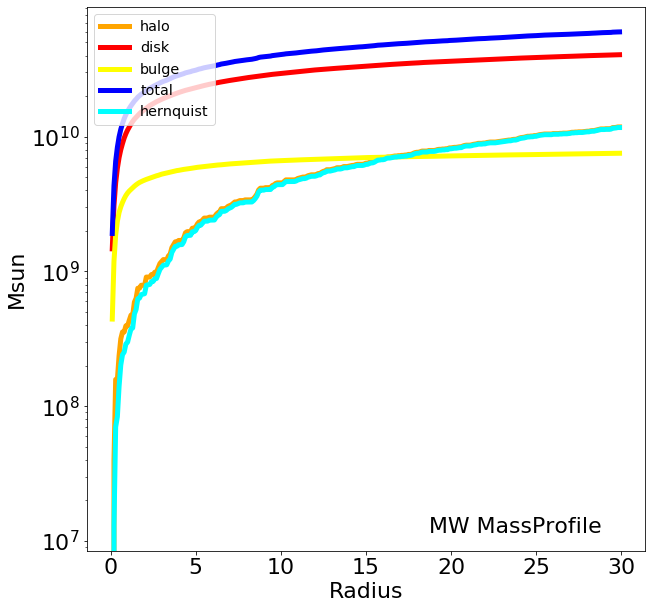

In [208]:
# Plot MW Mass Profile 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot Mass Profile

# Mass profile for halo
plt.semilogy(r, MWhaloMass, color='orange', linewidth=5, label='halo')
# Mass profile for disk
plt.semilogy(r, MWdiskMass, color='red', linewidth=5, label='disk')
# Mass profile for bulge
plt.semilogy(r, MWbulgeMass, color='yellow', linewidth=5, label='bulge')
# Mass profile for total
plt.semilogy(r, MWtotalMass, color='blue', linewidth=5, label='total')
# Mass profile for Hernquist
plt.semilogy(r, MWherMass, color='cyan', linewidth=5, label='hernquist')

# Add axis labels
plt.xlabel('Radius', fontsize=22)
plt.ylabel('Msun', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize='x-large')

#add figure text
plt.figtext(0.6, 0.15, 'MW MassProfile', fontsize=22)


In [242]:
M31 = MassProfile("M31", 0)

In [209]:
M31haloMass = M31.MassEnclosed(1, r)
M31diskMass = M31.MassEnclosed(2, r)
M31bulgeMass = M31.MassEnclosed(3, r)
M31totalMass = M31.MassEnclosedTotal(r)


In [210]:
M31herMass = M31.HernquistMass(0.15,r)

Text(0.6, 0.15, 'M31 MassProfile')

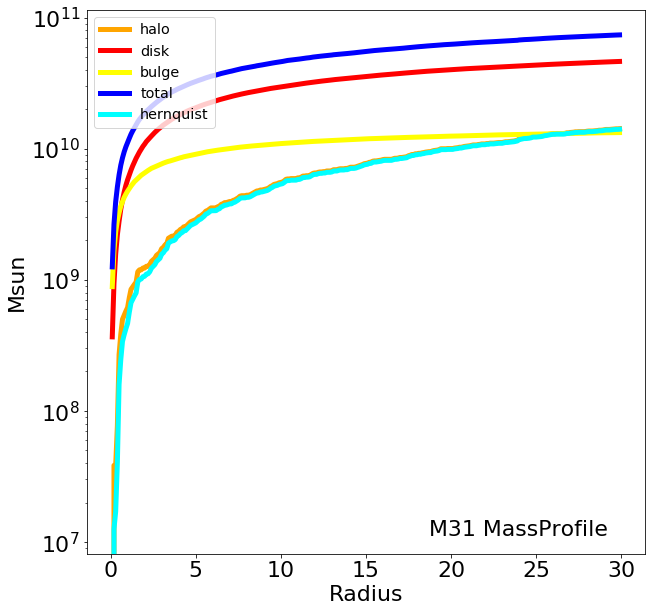

In [211]:
# Plot M31 Mass Profile 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot Mass Profile

# Mass profile for halo
plt.semilogy(r, M31haloMass, color='orange', linewidth=5, label='halo')
# Mass profile for disk
plt.semilogy(r, M31diskMass, color='red', linewidth=5, label='disk')
# Mass profile for bulge
plt.semilogy(r, M31bulgeMass, color='yellow', linewidth=5, label='bulge')
# Mass profile for total
plt.semilogy(r, M31totalMass, color='blue', linewidth=5, label='total')
# Mass profile for Hernquist
plt.semilogy(r, M31herMass, color='cyan', linewidth=5, label='hernquist')

# Add axis labels
plt.xlabel('Radius', fontsize=22)
plt.ylabel('Msun', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize='x-large')

#add figure text
plt.figtext(0.6, 0.15, 'M31 MassProfile', fontsize=22)



In [243]:
M33 = MassProfile("M33", 0)

In [213]:
M33haloMass = M33.MassEnclosed(1, r)
M33diskMass = M33.MassEnclosed(2, r)
M33totalMass = M33.MassEnclosedTotal(r)

In [214]:
M33herMass = M33.HernquistMass(0.15,r)

Text(0.6, 0.15, 'M33 MassProfile')

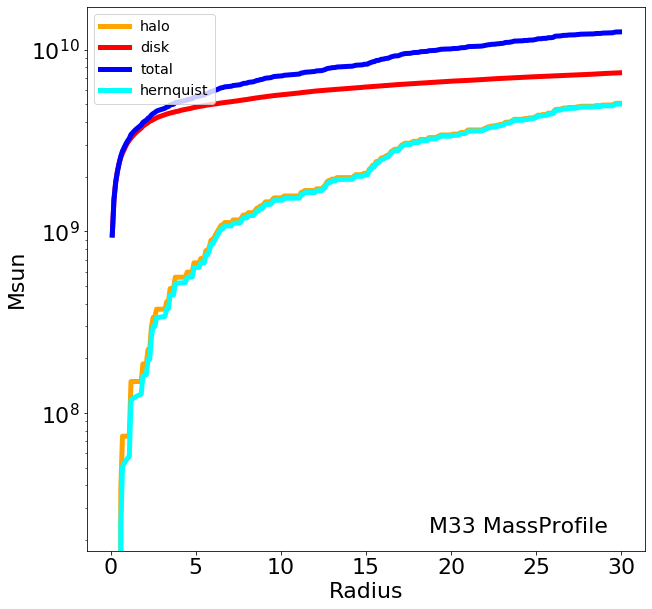

In [215]:
# Plot M31 Mass Profile 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot Mass Profile

# Mass profile for halo
plt.semilogy(r, M33haloMass, color='orange', linewidth=5, label='halo')
# Mass profile for disk
plt.semilogy(r, M33diskMass, color='red', linewidth=5, label='disk')
# Mass profile for total
plt.semilogy(r, M33totalMass, color='blue', linewidth=5, label='total')
# Mass profile for Hernquist
plt.semilogy(r, M33herMass, color='cyan', linewidth=5, label='hernquist')

# Add axis labels
plt.xlabel('Radius', fontsize=22)
plt.ylabel('Msun', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize='x-large')

#add figure text
plt.figtext(0.6, 0.15, 'M33 MassProfile', fontsize=22)


In [241]:
MWhaloVel = MW.CircularVelocity(1, r)
MWdiskVel = MW.CircularVelocity(2, r)
MWbulgeVel = MW.CircularVelocity(3, r)
MWtotalVel = MW.CircularVelocityTotal(r)

In [244]:
MWherVel = MW.HernquistVCirc(0.15,r)

Text(0.6, 0.15, 'MW VelocityProfile')

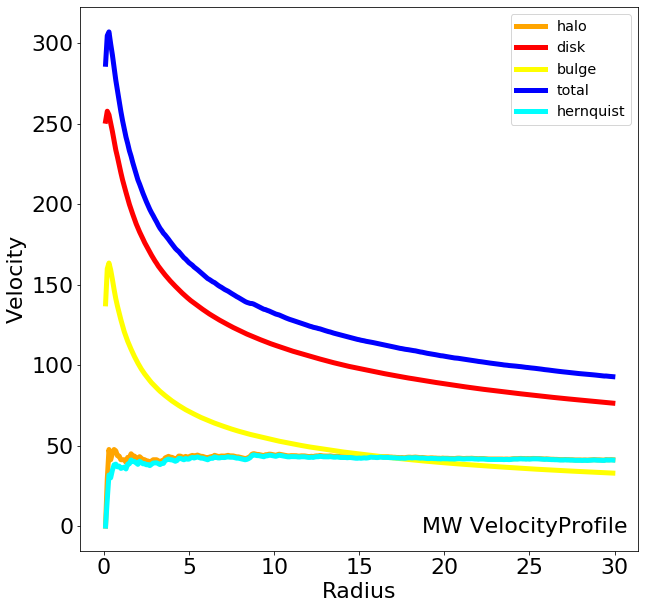

In [250]:
# Plot MW Velocity Profile 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot Velocity Profile

# Mass profile for halo
plt.plot(r, MWhaloVel, color='orange', linewidth=5, label='halo')
# Mass profile for disk
plt.plot(r, MWdiskVel, color='red', linewidth=5, label='disk')
# Mass profile for bulge
plt.plot(r, MWbulgeVel, color='yellow', linewidth=5, label='bulge')
# Mass profile for total
plt.plot(r, MWtotalVel, color='blue', linewidth=5, label='total')
# Mass profile for Hernquist
plt.plot(r, MWherVel, color='cyan', linewidth=5, label='hernquist')

# Add axis labels
plt.xlabel('Radius', fontsize=22)
plt.ylabel('Velocity', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

#add figure text
plt.figtext(0.6, 0.15, 'MW VelocityProfile', fontsize=22)



In [247]:
M31haloVel = M31.CircularVelocity(1, r)
M31diskVel = M31.CircularVelocity(2, r)
M31bulgeVel = M31.CircularVelocity(3, r)
M31totalVel = M31.CircularVelocityTotal(r)
M31herVel = M31.HernquistVCirc(0.15,r)

Text(0.6, 0.15, 'M31 VelocityProfile')

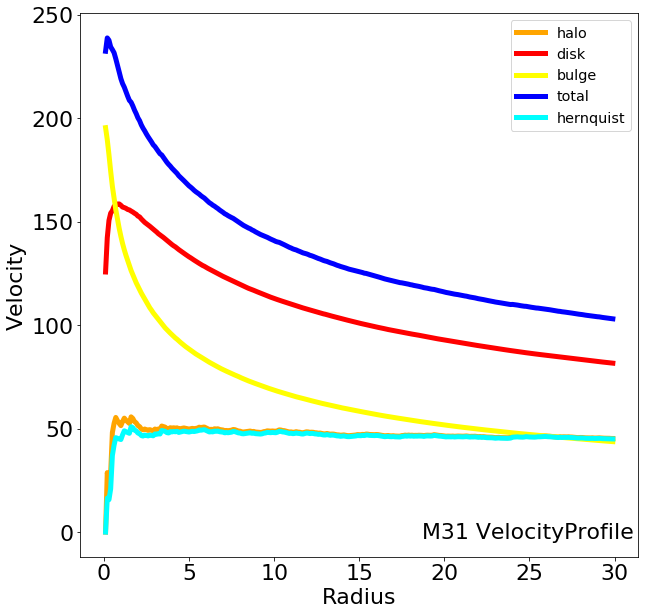

In [249]:
# Plot M31 Velocity Profile 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot Velocity Profile

# Mass profile for halo
plt.plot(r, M31haloVel, color='orange', linewidth=5, label='halo')
# Mass profile for disk
plt.plot(r, M31diskVel, color='red', linewidth=5, label='disk')
# Mass profile for bulge
plt.plot(r, M31bulgeVel, color='yellow', linewidth=5, label='bulge')
# Mass profile for total
plt.plot(r, M31totalVel, color='blue', linewidth=5, label='total')
# Mass profile for Hernquist
plt.plot(r, M31herVel, color='cyan', linewidth=5, label='hernquist')

# Add axis labels
plt.xlabel('Radius', fontsize=22)
plt.ylabel('Velocity', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

#add figure text
plt.figtext(0.6, 0.15, 'M31 VelocityProfile', fontsize=22)




In [251]:
M33haloVel = M33.CircularVelocity(1, r)
M33diskVel = M33.CircularVelocity(2, r)
M33totalVel = M33.CircularVelocityTotal(r)
M33herVel = M33.HernquistVCirc(0.15,r)

Text(0.6, 0.15, 'M31 VelocityProfile')

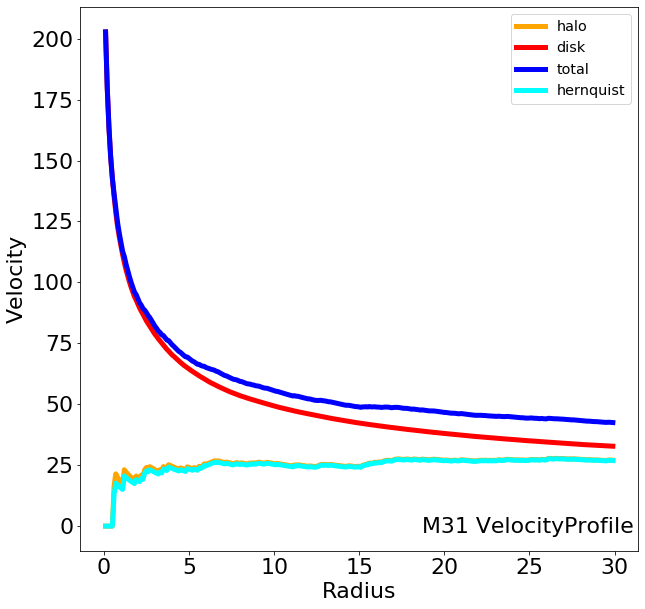

In [252]:
# Plot M33 Velocity Profile 
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot Velocity Profile

# Mass profile for halo
plt.plot(r, M33haloVel, color='orange', linewidth=5, label='halo')
# Mass profile for disk
plt.plot(r, M33diskVel, color='red', linewidth=5, label='disk')
# Mass profile for total
plt.plot(r, M33totalVel, color='blue', linewidth=5, label='total')
# Mass profile for Hernquist
plt.plot(r, M33herVel, color='cyan', linewidth=5, label='hernquist')

# Add axis labels
plt.xlabel('Radius', fontsize=22)
plt.ylabel('Velocity', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

#add figure text
plt.figtext(0.6, 0.15, 'M31 VelocityProfile', fontsize=22)


